In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report
from sklearn.utils import class_weight

from lightgbm import LGBMClassifier

from scipy.stats import uniform as sp_uniform
import winsound

%matplotlib inline
sns.set()

In [2]:
IS_CLASSIFICATION = True
RANDOM_STATE = 7532
N_CV_FOLDS = 5
np.random.seed(RANDOM_STATE)

In [3]:
BEEP_FREQUENCY = 2500  # Set Frequency To 2500 Hertz
BEEP_DURATION = 2000  # Set Duration To 2000 ms

In [4]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

submission_template = pd.read_csv('data/sample_submission.csv')

In [5]:
target_column = train_data['Interest_Rate'].copy()
train_data = train_data.drop(columns=[target_column.name])

## Part I - Final Data Preparation and Pipeline Creation ##

Now, we collect ideas pertaining to feature engineering and turn them into a single function that we apply to our data.

In [6]:
def aggregate_num_column_by_cat_column(df, target_column, cat_column_name, num_column_name, 
                                       agg_function='mean', include_quotient=True):
    tmp = df.loc[:, [num_column_name, cat_column_name]]
    tmp = tmp.groupby(cat_column_name)[num_column_name].agg(agg_function)

    new_column_name = agg_function.capitalize() + '_' + num_column_name + '_by_' + cat_column_name
    df[new_column_name] = 0

    #old_column_counts = df[cat_column_name].value_counts()
    cat_column_values = df[cat_column_name].value_counts().index.tolist()

    for cat_column_value in cat_column_values:
        indx = df[cat_column_name] == cat_column_value
        df.loc[indx, new_column_name] = tmp[cat_column_value] #old_column_counts[cat_column_name] 
    
    if include_quotient:
        tmp = df.loc[:, [num_column_name, cat_column_name]]
        tmp = tmp.groupby(cat_column_name)[num_column_name].transform(agg_function)
    
        new_quotient_name = num_column_name + '_over_' + new_column_name
        df[new_quotient_name] = df[num_column_name] / tmp

In [7]:
def perform_feature_engineering(df):
    df = df.copy()
    df = df.drop(columns=['Loan_ID'])
    columns_to_drop = []
    
    #
    def convert_to_number(string):
        if ',' in string:
            return int(string.replace(',', ''))
        return int(string)
    
    column = 'Loan_Amount_Requested'
    df[column] = df[column].apply(convert_to_number).astype(np.int)
    
    
    #
    df['Open_To_All_Accounts'] = df['Number_Open_Accounts'] / df['Total_Accounts']
    df['Loan_To_Income'] = df['Loan_Amount_Requested'] / df['Annual_Income']
    df['Debt_To_Loan'] = df['Debt_To_Income'] * df['Annual_Income'] / df['Loan_Amount_Requested']
    
    
    #
    #old_column = 'Length_Employed'
    #new_column = 'Num_Length_Employed'
    #indx = df[old_column].isnull()
    #df.loc[indx, old_column] = 'missing'
    #
    #def convert_employment_length(row):
    #    if row == 'missing':
    #        return 0
    #    elif row == '< 1 year':
    #        return 1
    #    elif row == '10+ years':
    #        return 11
    #    else:
    #        return int(row[0]) + 1
    #
    #df[new_column] = df[old_column].copy().apply(convert_employment_length).astype(np.int8)
    
    
    #
    column = 'Home_Owner'
    indx = df[column].isin(('Other', 'None'))
    df.loc[indx, column] = np.NaN
    df.loc[df[column].isna(), column] = 'missing'    
    
    
    #
    column = 'Gender'
    df[column] = df[column].apply(lambda row: 1 if row == 'Male' else 0).astype(np.int8)
    
    
    #
    #column = 'Income_Verified'
    #df.loc[df[column] == 'VERIFIED - income', column] = 2  
    #df.loc[df[column] == 'VERIFIED - income source', column] = 1    
    #df.loc[df[column] == 'not verified', column] = 0
    #df[column] = df[column].astype(np.int8)
    
    #
    #column = 'Home_Owner'
    #indx = df[column].isin(('Other', 'None'))
    #df.loc[indx, column] = np.NaN
    #
    #df.loc[df[column] == 'Own', column] = 3  
    #df.loc[df[column] == 'Mortgage', column] = 2    
    #df.loc[df[column] == 'Rent', column] = 1
    #df.loc[df[column].isna(), column] = 0
    #df[column] = df[column].astype(np.int8)
    
    
    #
    old_column = 'Months_Since_Deliquency'
    new_column = 'Months_Since_Deliquency_missing'
    
    df[new_column] = 0
    df.loc[df[old_column].isnull(), new_column] = 1
    df[new_column] = df[new_column].astype(np.int8)
    
    
    #
    old_column = 'Annual_Income'
    new_column = 'Annual_Income_missing'
    
    df[new_column] = 0
    df.loc[df[old_column].isnull(), new_column] = 1
    df[new_column] = df[new_column].astype(np.int8)   
    
    #
    column = 'Inquiries_Last_6Mo'
    df[column] = df[column].astype(np.int8)
    
    
    # 
    column = 'Number_Open_Accounts'
    df[column] = df[column].astype(np.int8)
    
    
    #
    column = 'Total_Accounts'
    df[column] = df[column].astype(np.int8)
    
    
    #
    applicable_categorical_variables = ['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan']
    applicable_numeric_variables = ['Debt_To_Income', 'Loan_Amount_Requested']

    
    for cat_column_name in applicable_categorical_variables:
        for num_column_name in applicable_numeric_variables:
            aggregate_num_column_by_cat_column(df, target_column, cat_column_name, num_column_name)
            
    columns_to_drop.extend(['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan'])   
    
    
    # 
    df = df.drop(columns=columns_to_drop)
    
    return df

In [8]:
X_train = perform_feature_engineering(train_data)
X_test = perform_feature_engineering(test_data)

y_train = target_column

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 29 columns):
 #   Column                                                                    Non-Null Count   Dtype  
---  ------                                                                    --------------   -----  
 0   Loan_Amount_Requested                                                     164309 non-null  int32  
 1   Annual_Income                                                             139207 non-null  float64
 2   Debt_To_Income                                                            164309 non-null  float64
 3   Inquiries_Last_6Mo                                                        164309 non-null  int8   
 4   Months_Since_Deliquency                                                   75930 non-null   float64
 5   Number_Open_Accounts                                                      164309 non-null  int8   
 6   Total_Accounts                                      

Preprocessing pipeline.

In [10]:
preprocessing_pipeline = Pipeline(
    steps=
    [ 
        ('var_threshold', VarianceThreshold()),
        ('imputer', IterativeImputer(
            estimator=None,
            max_iter=25, 
            initial_strategy='mean',
            skip_complete=True, 
            random_state=RANDOM_STATE, 
            add_indicator=False)),   
    ],
    memory=None
)

## Part II - Model Training and Evaluation ## 

In [11]:
def cv_results(X, y, search_mode, estimator, parameters, scoring, 
               n_iter=16, verbose=0, cv=5, random_state=RANDOM_STATE, n_jobs=-1):
    """
    Performs either grid search or randomized search (depending on the search mode), 
    displays best score and parameters, and returns the fitted grid.
    If the grid search is selected, the parameters n_iter and random_state are ignored. 
    """
    
    if search_mode not in ['grid_search', 'randomized_search']:
        raise ValueError('Search mode should be either "grid_search" or "randomized_search"')
        
    if search_mode == 'grid_search': 
        grid = GridSearchCV(
            estimator=estimator, 
            param_grid=parameters, 
            scoring=scoring, 
            verbose=verbose, 
            cv=cv, 
            n_jobs=n_jobs)
    else: 
        grid = RandomizedSearchCV(
            estimator=estimator, 
            param_distributions=parameters, 
            scoring=scoring, 
            n_iter=n_iter, 
            verbose=verbose, 
            cv=cv, 
            n_jobs=n_jobs, 
            random_state=random_state)        
    
    grid.fit(X, y)
    
    print(f'Best parameters:\n{grid.best_params_}')
    print()
    print(f'Best score: {grid.best_score_}')
    print()
    
    return grid


def model_results(y_true, y_pred, label='Model'):
    print(label + ' results:\n')

    print(f'Model Accuracy Score: {accuracy_score(y_true, y_pred)}\n')
    print(f'Confusion Matrix:\n{pd.crosstab(y_true, y_pred, colnames=["  prediction"])}\n')   
    print(f'Classification Report:\n{classification_report(y_true, y_pred)}\n')
    
    return None


# N-fold splitter for the cross_validation
if IS_CLASSIFICATION:
    N_folds = StratifiedKFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
else:
    N_folds = KFold(n_splits=N_CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    

# Custom scoring function
def weighted_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

weighted_f1_score = make_scorer(weighted_f1, greater_is_better=True)

**LightGBM**

In [12]:
# mostly default parameters
LGBM_model = LGBMClassifier(
    boosting_type='gbdt', 
    max_depth=-1, 
    subsample_for_bin=200000, 
    objective='multiclass', 
    is_unbalance=True, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    random_state=RANDOM_STATE, 
    n_jobs=-1, 
    silent=True, 
    importance_type='gain'
)

LGBM_pipeline = Pipeline([
    ('preprocessing_pipeline', preprocessing_pipeline), 
    ('model', LGBM_model)
])

LGBM_param_grid = {
    'model__learning_rate': [0.1], 
    'model__n_estimators': [225], 
    'model__num_leaves': [31, 63],     
    'model__subsample': [0.005], 
    'model__colsample_bytree': [0.9], 
    'model__min_child_samples': [40], 
    'model__reg_alpha': [5],
    'model__reg_lambda': [5], 
    'model__is_unbalanced': [True]
}

LGBM_param_distr = {
    'model__learning_rate': [0.5], 
    'model__n_estimators': [11],
    'model__num_leaves': [15, 31, 46], 
    'model__subsample': sp_uniform(0, 1), 
    'model__colsample_bytree': sp_uniform(0, 1), 
    'model__min_child_samples': [1, 20], 
    'model__reg_alpha': sp_uniform(0, 1),
    'model__reg_lambda': sp_uniform(0, 1)
}

switch = 'grid'

In [13]:
if switch == 'grid':
    search_mode, parameters ='grid_search', LGBM_param_grid
else:
    search_mode, parameters ='randomized_search', LGBM_param_distr

In [14]:
%%time
LGBM_grid = cv_results(
    X_train, y_train, 
    search_mode=search_mode, 
    estimator=LGBM_pipeline, 
    parameters=parameters, 
    scoring=weighted_f1_score, 
    n_iter=180, 
    verbose=10, 
    cv=N_folds.split(X_train, y_train)
)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  1.5min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  1.5min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.7min remaining:   42.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.2min finished


Best parameters:
{'model__colsample_bytree': 0.9, 'model__is_unbalanced': True, 'model__learning_rate': 0.1, 'model__min_child_samples': 40, 'model__n_estimators': 225, 'model__num_leaves': 63, 'model__reg_alpha': 5, 'model__reg_lambda': 5, 'model__subsample': 0.005}

Best score: 0.5361612418169754

Wall time: 2min 32s


In [15]:
winsound.Beep(BEEP_FREQUENCY, BEEP_DURATION)

In [16]:
LGBM_train_preds = LGBM_grid.predict(X_train)
model_results(y_train, LGBM_train_preds, label='LGBM')

LGBM results:

Model Accuracy Score: 0.6007522412040728

Confusion Matrix:
  prediction       1      2      3
Interest_Rate                     
1              11627  18061   4118
2               5492  48782  16306
3               1592  20031  38300

Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.34      0.44     33806
           2       0.56      0.69      0.62     70580
           3       0.65      0.64      0.65     59923

    accuracy                           0.60    164309
   macro avg       0.61      0.56      0.57    164309
weighted avg       0.61      0.60      0.59    164309




c:\users\rafal\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  


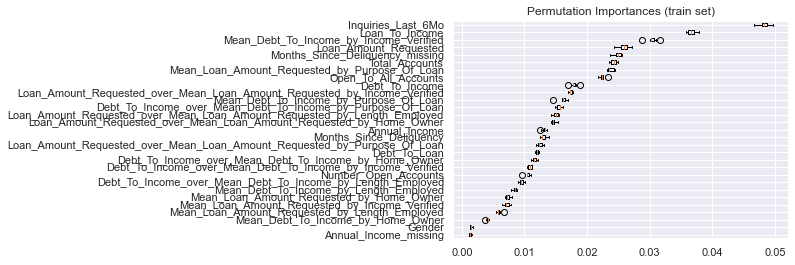

In [17]:
perm_imp = permutation_importance(
    LGBM_grid, 
    X_train, 
    y_train, 
    scoring=weighted_f1_score, 
    n_repeats=10, 
    random_state=RANDOM_STATE, 
    n_jobs=1)
sorted_idx = perm_imp.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(perm_imp.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

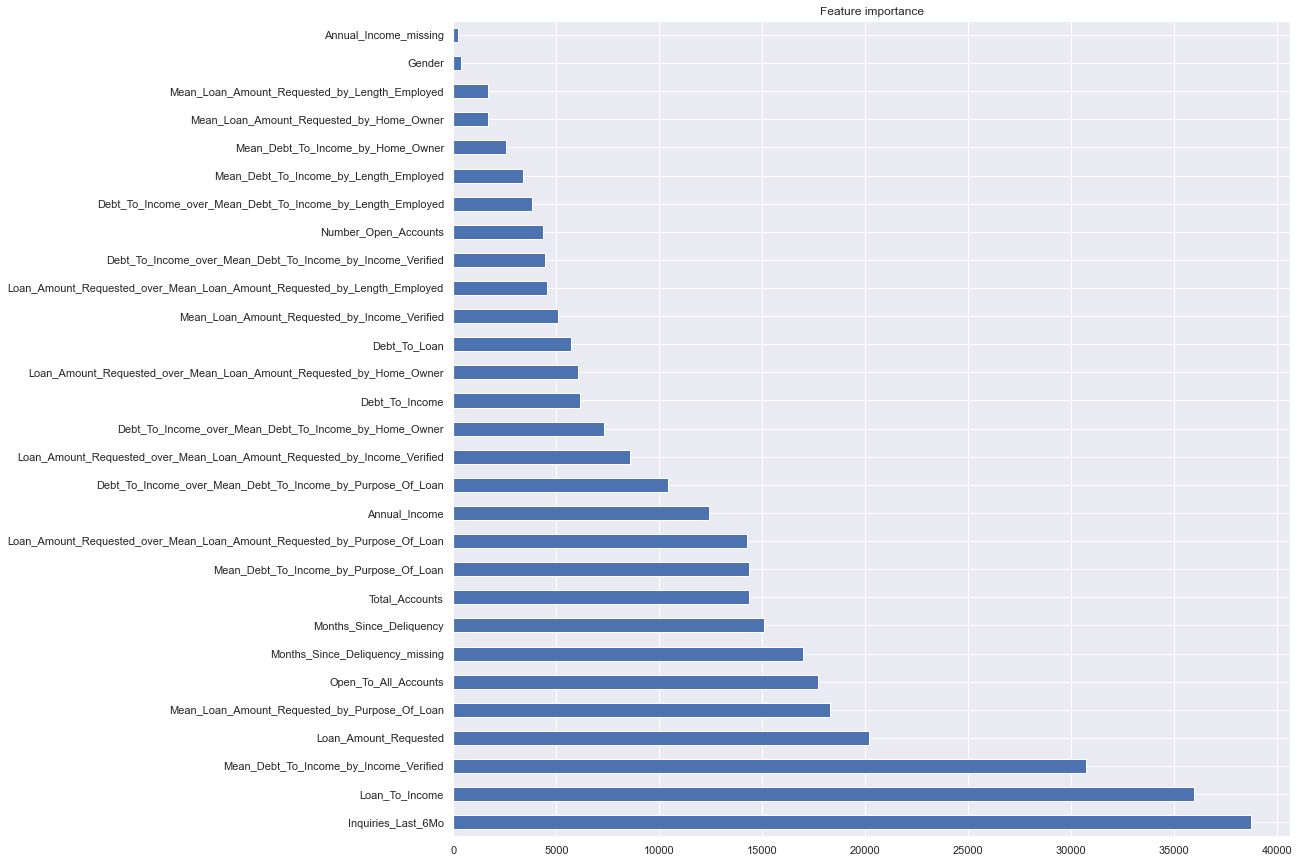

In [18]:
feature_importance = LGBM_grid.best_estimator_.named_steps['model'].feature_importances_

col_names = list(X_train.columns)

plt.figure(figsize=(15,15))
important_features = pd.Series(feature_importance, index=col_names)
important_features.nlargest(len(col_names)).plot(kind='barh')
plt.title('Feature importance')
plt.show()

Get predictions and prepare a submission.

In [19]:
submission_template[target_column.name] = LGBM_grid.predict(X_test) 
submission_template.to_csv('submissions/submission_LGBM_final.csv', index=False)

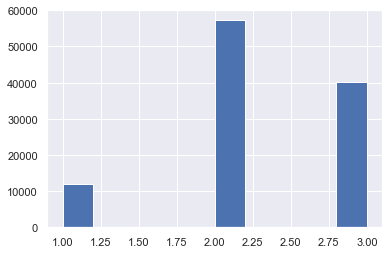

In [20]:
submission_template[target_column.name].hist();